## MC
------------

In [1]:
import numpy as np
import pandas as pd
#from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import datetime as dt
#from stock_forecasting.config import PROCESSED_DATA_DIR

In [3]:
%pip install setuptools==62.0.0 wheel

  Attempting uninstall: setuptools
    Found existing installation: setuptools 58.1.0
    Uninstalling setuptools-58.1.0:
      Successfully uninstalled setuptools-58.1.0
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Daniela\Desktop\Fac\3ºano\Lab_IACD\Project2\stocks-prediction-labia\.venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [2]:
%pip install --upgrade pip

  Attempting uninstall: pip
    Found existing installation: pip 21.2.4
    Uninstalling pip-21.2.4:
      Successfully uninstalled pip-21.2.4
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install -e ..

Obtaining file:///C:/Users/Daniela/Desktop/Fac/3%C2%BAano/Lab_IACD/Project2/stocks-prediction-labia
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Checking if build backend supports build_editable: started
  Checking if build backend supports build_editable: finished with status 'done'
  Getting requirements to build editable: started
  Getting requirements to build editable: finished with status 'done'
  Preparing editable metadata (pyproject.toml): started
  Preparing editable metadata (pyproject.toml): finished with status 'done'
  Building editable for stock_forecasting (pyproject.toml): started
  Building editable for stock_forecasting (pyproject.toml): finished with status 'done'
  Created wheel for stock_forecasting: filename=stock_forecasting-0.0.1-py3-none-any.whl size=1180 sha256=f5a1556838de2bbc36a70c7e9c3bb1bd82fd99dd00dcadca88f8fc7cfd190da4
  Stored in directory: C:\Users\Daniela\AppData\Local\Temp\pip-ephem-wheel-ca

In [ ]:
from stock_forecasting.features import *
from stock_forecasting.plots import *
from stock_forecasting.config import PROCESSED_DATA_DIR, RAW_DATA_DIR, MODELS_DIR
from stock_forecasting.modeling.train import train_lstm, predict

ModuleNotFoundError: No module named 'stock_forecasting'

---------------

In [4]:
%pwd

'c:\\Users\\Daniela\\Desktop\\Fac\\3ºano\\Lab_IACD\\Project2\\stocks-prediction-labia\\notebooks'

In [3]:
from pathlib import Path

PROJ_ROOT = Path('c:\\Users\\Daniela\\Desktop\\Fac\\3ºano\\Lab_IACD\\Project2\\stocks-prediction-labia')
# logger.info(f"PROJ_ROOT path is: {PROJ_ROOT}")

DATA_DIR = PROJ_ROOT / "data"
RAW_DATA_DIR = DATA_DIR / "raw"
INTERIM_DATA_DIR = DATA_DIR / "interim"
PROCESSED_DATA_DIR = DATA_DIR / "processed"
EXTERNAL_DATA_DIR = DATA_DIR / "external"

In [5]:
df = pdr.DataReader('^SPX', data_source='stooq', start='2010-1-1', end='2023-12-31')

In [4]:
def get_data(stocks, start, end):
    # stockData = pdr.get_data_yahoo(stocks, start=start, end=end)
    # stockData = stockData['Close']
    stockData = pd.read_pickle(PROCESSED_DATA_DIR / "filtered.pkl")
    returns = stockData.xs("Close", level="Price", axis=1).pct_change()
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    return meanReturns, covMatrix

stockList = ['CBA', 'BHP', 'TLS', 'NAB', 'WBC', 'STO']
stocks = [stock + '.AX' for stock in stockList]
endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days = 300)

meanReturns, covMatrix = get_data(stocks, startDate, endDate)

print(meanReturns)

#give random weights to portfolio
weights = np.random.random(len(meanReturns))
weights/=np.sum(weights)

print(weights)



Ticker
HAL     0.000488
K       0.000235
IRM     0.000732
HES     0.000624
KEY     0.000660
          ...   
DLR     0.000604
DD      0.000419
SWK     0.000461
MSFT    0.000940
ROK     0.000787
Length: 392, dtype: float64
[5.76939733e-04 1.79351035e-03 1.48409223e-03 5.05783465e-03
 1.06559531e-03 3.75806538e-04 1.16276394e-03 3.86669733e-03
 2.34982851e-03 3.00591376e-03 8.10906689e-04 2.58044346e-03
 2.69158465e-03 4.46323924e-03 5.00991010e-03 2.08652392e-03
 3.46548715e-03 3.04458210e-04 4.36015280e-03 4.59047883e-03
 1.62730538e-03 3.07373546e-03 3.63066423e-03 1.56861444e-03
 4.41958888e-03 2.78556672e-03 1.11621249e-03 2.77718851e-03
 3.39820525e-03 2.83869326e-04 4.94669319e-03 1.44756601e-04
 1.11344088e-03 3.78316422e-03 3.42724659e-04 1.45440213e-03
 8.53797991e-04 2.45893804e-03 1.94214416e-04 2.10757642e-03
 2.47634877e-04 3.14209348e-03 6.92299742e-05 8.54771513e-04
 1.21381875e-03 1.27214750e-03 1.73559116e-03 3.43797006e-03
 4.12600916e-04 5.09387078e-03 4.73507247e-03 

    Instead of using random weigths:

-based on annual volatility

-sharp ratio

-minimum variance portfolio

-ERC(Equal Risk Contribution) : Assign weights so that each asset contributes equally to portfolio risk. This is a more advanced form of risk parity


In [ ]:
raw_data = pd.read_pickle(RAW_DATA_DIR / "raw.pkl")
raw_data = delete_recent(raw_data, threshold=0)
stock_stats = calculate_stock_stats(raw_data)

NameError: name 'calculate_stock_stats' is not defined

In [ ]:
weights = np.random.random(len(meanReturns))
weights/=np.sum(weights) #ajust so that sum is 1

print(weights)

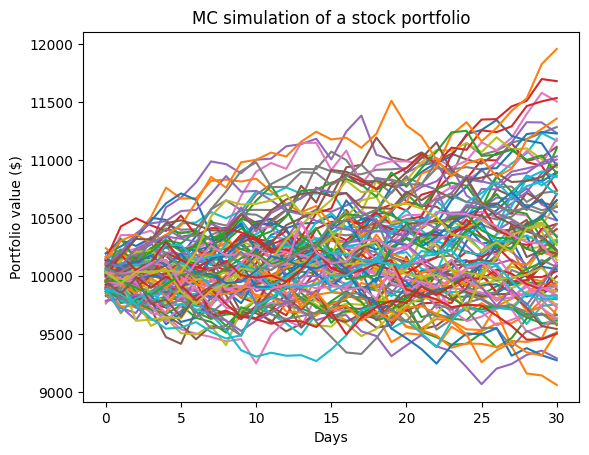

In [5]:
#MC simulater
#nº of simulations
mc_simes = 100
T = 31 #days

meanM = np.full(shape=(T, len(weights)), fill_value=meanReturns)
meanM = meanM.T #transpose

portfolio_sins = np.full(shape=(T, mc_simes), fill_value=0.0)

initialPortfolio = 10000 #started with initialPortfolio money

for m in range(0, mc_simes):
    #mc loops
    Z = np.random.normal(size=(T, len(weights))) #T com o nº de stocks
    L = np.linalg.cholesky(covMatrix) #lower triangle // nº of stocks by the n of stocks 

    dailyReturns = meanM + np.inner(L, Z)
    portfolio_sins[:, m] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*initialPortfolio

plt.plot(portfolio_sins)
plt.ylabel('Portfolio value ($)')
plt.xlabel('Days')
plt.title('MC simulation of a stock portfolio')
plt.show()


In [6]:
#value of risk and conditional value of risk

def mcVar(returns, alpha = 5):
    ''' 
    input: pandas series of returns 
    output: percentile on return distribution to a given confidence level alpha
    '''

    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    else:
        raise TypeError("Expected a pandas data series.")


def mcCVar(returns, alpha = 5):
    ''' 
    input: pandas series of returns 
    output: CVar or Expected Shortfall to a given confidence level alpha
    '''

    if isinstance(returns, pd.Series):
        belowVar = returns <= mcVar(returns, alpha=alpha)
        return returns[belowVar].mean()
    else:
        raise TypeError("Expected a pandas data series.")
    

portResults = pd.Series(portfolio_sins[-1,:])

VaR = initialPortfolio - mcVar(portResults, alpha=5)
CVaR = initialPortfolio - mcCVar(portResults, alpha=5)

print(f'Var ${format(round(VaR, 2))}')  #limite (o valor esperado a perder quando fazer inicial - variancia)
print(f'Var ${format(round(CVaR, 2))}') #risco conditional risc (para baixo do valor obtido em cima)

Var $480.85
Var $671.78


> next part is an example

In [4]:
# functions from the pandas library to record historical index prices from the Stooq platform; the start 
df = wb.DataReader('^SPX', data_source='stooq', start='2010-1-1', end='2021-3-11')

In [5]:
# calculation of logarithmic rates of return, average rate of return and standard deviation and drift
logarithmic_returns = np.log(1 + df['Close'].pct_change())
mu_r = logarithmic_returns.mean()
std_r = logarithmic_returns.std()
drift = mu_r - 0.5*(std_r**2)
wyniki = []

In [ ]:
# function that generates 20,000 rates of return consecutive trading days according to Monte Carlo simulation
for i in range(20000):
    d_returns = np.exp(drift + std_r * norm.ppf(np.random.rand(252)))
    list_prices = [df['Close'][0]]
    # function that calculates the new price after taking into account the generated rate of return from the simulation
    for x in d_returns:
        list_prices.append(list_prices[-1]*x)
    plt.plot(list_prices)
    wyniki.append(list_prices)
    lista=[]
    # A loop that adds the results to the time series to be visualized
    for z in results:
        lista.append(z[-1])

C:\Users\Daniela\AppData\Local\Temp\ipykernel_14472\2799356803.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  list_prices = [df['Close'][0]]


KeyboardInterrupt: 

-----

In [ ]:
"""
Compute the logarithmic returns of Google stock
"""
log_return = np.log(1 + data.pct_change())
#Plot
sns.distplot(log_returns.iloc[1:])
plt.xlabel("Daily Return")
plt.ylabel("Frequency")

logarithmic_returns = np.log(1 + df['Close'].pct_change())
mu_r = logarithmic_returns.mean()
std_r = logarithmic_returns.std()
drift = mu_r - 0.5*(std_r**2)

In [ ]:
#compute drift
u = log_returns.mean()
var = log_returns.var()
drift = u - (0.5*var)

In [ ]:
'''
Compute the Variance and Daily Returns
In this step we have to generate random variables for every day 
forecasted and for every simulation trial we will run

31 dias->Janeiro(valor de previsão final) 
'''
stdev = log_returns.std()
days = 31
trials = 10000
Z = norm.ppf(np.random.rand(days, trials)) #days, trials
daily_returns = np.exp(drift.values + stdev.values * Z)

In [ ]:
''' 
Calculating the stock price for every trial
'''
price_paths = np.zeros_like(daily_returns)
price_paths[0] = data.iloc[-1]
for t in range(1, days):
    price_paths[t] = price_paths[t-1]*daily_returns[t]

''' 
With the price_paths matrix, now you can calculate the probability of profitability, 
or the expected annualized returm, for example. 
'''

In [ ]:
#fazer func
def MC(df, predict_date:31, n_diff_predicts):
    #P1 -> Create simulations to explore a variety of portfolio allocations
    #get returns of stocks
    #fazer log
    log_returns = np.log(1 + df['Close'].pct_change())
    #obter mean and var
    u = log_returns.mean()
    var = log_returns.var()
    drift = u - (0.5*var)

    #deviation between the two, try to understand

    #P2 -> identify the one that optimizes your objective (e.g., maximize return, minimize risk, or optimize the Sharpe ratio)
    


    ...

------------
Automating the Monte Carlo Simulations and Showing CAPM Metrics
------------

----------
References

> https://medium.com/analytics-vidhya/monte-carlo-simulations-for-predicting-stock-prices-python-a64f53585662
> https://journals.ue.wroc.pl/fins/article/download/138/7/458
>https://youtu.be/f9MAFvP5-pA